<a href="https://colab.research.google.com/github/HxyScotthuang/Graph-Foundation-Models-LoG-2025-Tutorial/blob/main/tutorial-part-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Graph Foundation Model Tutorial (Part 2): Link Prediction on Knowledge Graphs

Unlike standard graphs, in a **knowledge graph (KG)**, each **edge** not only connects two nodes but also has a **relation type** that defines the relationship between them.  

Our goal is to **build and implement a graph foundation model** specifically designed for **knowledge graphs**. This model will be capable of **generalizing** across different KGs by learning **relation invariants**, allowing it to work even when encountering new and unseen relations.  

Note, there is no textual information inside: all knowledge graph foundation models (KGFMs) are designed to generalize *solely* based on structural learning. One can always integrate additional textual embeddings.




References:
* Galkin, M., Yuan, X., Mostafa, H., Tang, J., and Zhu, Z. Towards foundation models for knowledge graph reasoning. In ICLR, 2024.

* Huang, X., Barcelo, P., Bronstein, M. M., Ceylan, İ.İ., Galkin, M., Reutter, J. L., & Romero Orth, M. (2025). How Expressive are Knowledge Graph Foundation Models? In ICML, 2025.

* Kim, J., Huang, X., Olejniczak, K., Min, K., Bronstein, M., Hong, S. and Ceylan, İ.İ., 2025. Flock: A Knowledge Graph Foundation Model via Learning on Random Walks. arXiv preprint arXiv:2510.01510.

Authors: Xingyue Huang

## Part 1: Task setup



### 1.1 Inductive link prediction on knowledge graph with unseen relation types

Unlike standard graphs, **knowledge graphs (KGs)**  are directed and contain **typed relations**. For a **foundation model**, it is crucial to **generalize** to entirely new KGs with unseen relations.  

- To achieve this, models must learn **relation invariants**—structural properties of relations that remain consistent across different knowledge graphs, even when the specific relation labels differ.  

- By capturing these **transferable relational patterns**, the model can effectively apply its learned knowledge to **new KGs** with **different relational vocabularies**, enabling **zero-shot** or **few-shot** generalization.  

### 1.2 Example

For instance, consider two knowledge graphs (KGs) that use **disjoint sets of relations**. Suppose the model is trained on $ G_{\text{train}} $ and the goal is to predict the missing link:  
$
\mathsf{produce}(\mathsf{Intel},\mathsf{SemiConductors})
$
in $ G_{\text{test}} $.  

The key challenge here is that the model has **never seen** the relation **`produce`** during training!

Ideally, the model will **generalize** by learning **relation invariants** that align similar structural roles across graphs. Specifically, it should recognize mappings such as:  

- $ \mathsf{research} \leftrightarrow \mathsf{produce} $
- $ \mathsf{provide} \leftrightarrow \mathsf{supply} $

where these relations play **similar structural roles** in their respective graphs.


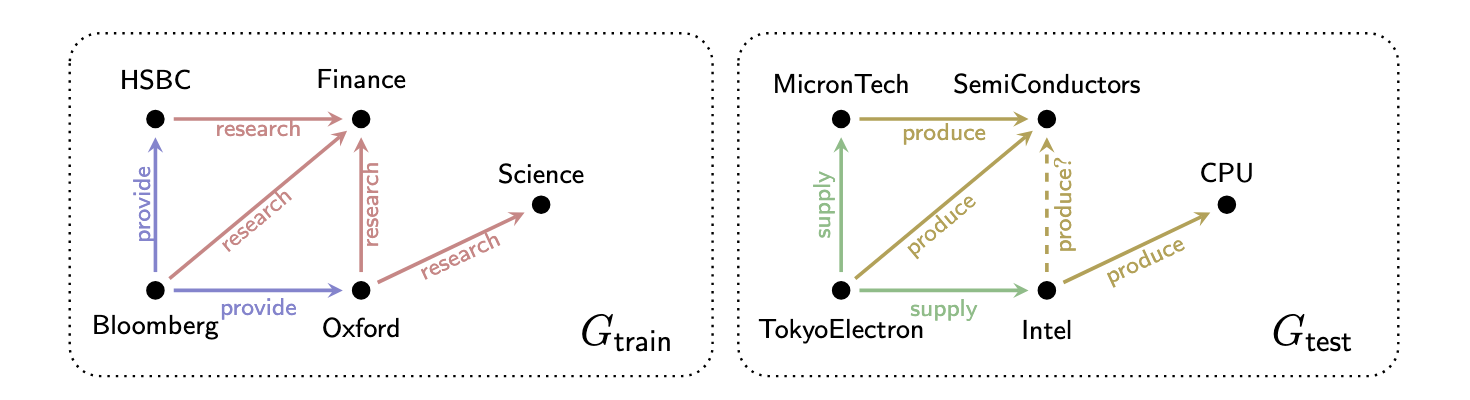

### 1.3 Node & relation permutation invariance and equivariance

In our setting, node IDs and relation names carry no meaning: only the KG structure matters. **Node equivariance** means that if we relabel nodes with any permutation, the internal node/link representations are relabeled in exactly the same way, so the decoded link scores are *invariant* to node permutations.

Similarly, **relation equivariance** means that if we consistently permute the relation vocabulary, the learned relation representations just get relabeled, yielding link and relation invariants that depend only on how relations participate in motifs, not on their textual names or indices.



## Part 2: Building a Knowledge Graph Foundation Model

### 2.1 Install dependencies

> **Note**: If you're running this tutorial in **Google Colab**, run the cell below to install the required dependencies.  
> Otherwise, ensure you have the following packages installed in your environment.

**Required packages:**
- PyTorch 2.3.0 (with CUDA 11.8)
- PyTorch Geometric 2.5.3

Make sure you have turn on **GPU**!


In [1]:
%%capture
!pip install torch-geometric==2.5.3

In [2]:
#@title Import necessary libraries
%%capture
import torch
import copy
import shutil
from torch import nn
from torch.nn import functional as F
from typing import Tuple
from functools import reduce
import os
import sys
import math
import pprint
from itertools import islice
import torch_geometric as pyg
from torch import optim
from torch.utils import data as torch_data
from torch_geometric.utils import scatter
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip



### 2.2 Model Architecture: ULTRA

We proceed to build an instance of knowledge graph foundation model: ULTRA.

Given a knowledge graph **G** = (V, E, R), where $V$ is the set of nodes, $E$ is the set of directed edges with relation types, and $R$ is the set of relations. and a query **q(u, ?)** where $q \in R$ is the querying relation and $u \in V$ is the source node, ULTRA first constructs an relation graph **L(G) = ($V_L$, $E_L$, $R_L$)** where nodes represent relations and edges define **four fundamental relation types**:  

1. **Tail-to-Head (t2h)**: Exists if two relations form a chain **r₁(u,v), r₂(v,w)** in G.  
2. **Head-to-Head (h2h)**: Exists if **r₁(v,u), r₂(v,w)** form a pattern in G.  
3. **Head-to-Tail (h2t)**: Exists if **r₁(v,u), r₂(w,v)** form a pattern in G.  
4. **Tail-to-Tail (t2t)**: Exists if **r₁(u,v), r₂(w,v)** form a pattern in G.  


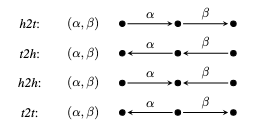

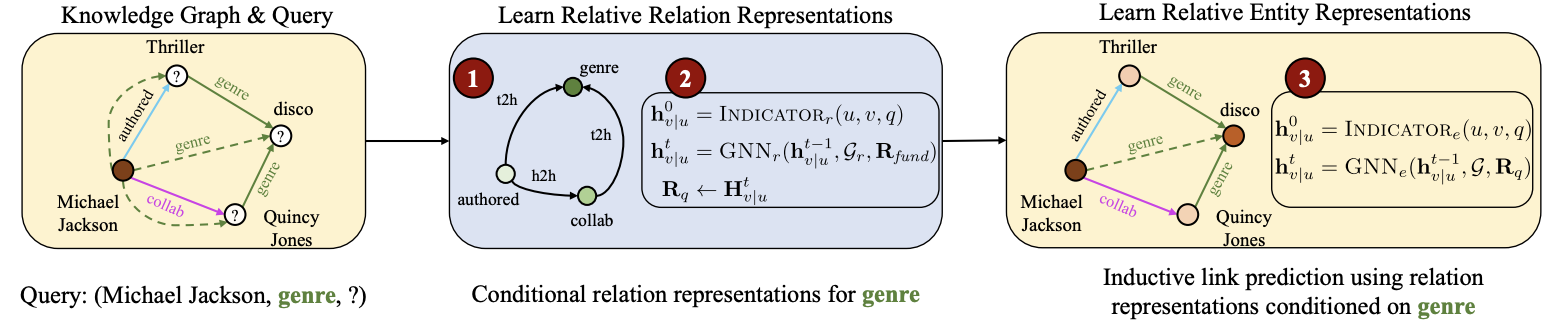

**Remark.** Notice that we can always go beyond the four proposed fundemental relations. In fact, MOTIF (Huang et al. 2025) shows a strict generalization over this types of KGFM and prove a strict expressivity hierachy when the model consider different fundemental relations (or `motif`).

### 2.4 Relation Encoder  
We consider a state of the art inductive (on node) link prediction model on knowledge graph:[NBFNet](https://arxiv.org/pdf/2106.06935), which generates **relation representations** using message passing:  

1. **Initialization:**  
   - For each node, if **r = q**, initialize with **1ᵈ**; otherwise, **0**.  

2. **Update Rule:**  
   - Aggregate neighboring relation embeddings using learnable vectors **zᵣₗ** and update using a **feedforward network** with ReLU activation:  

$$
h_{r|q}^{(t+1)} = \sigma\left(W^{(t)} \left[ h_{r|q}^{(0)} \parallel \sum_{r' \in N_{R_L}(r)} h_{r'|q}^{(t)} \odot z_{r_L} \right] + b^{(t)}\right)
$$




In [3]:
#@title Download the checkpoints
#@markdown To run ULTRA, we first need to download the pre-trained checkpoint file. The expected file is **`3g_reproduced.pth`**, which contains the model weights for evaluation.

%%capture
!wget --no-check-certificate -O 3g_reproduced.pth 'https://www.dropbox.com/scl/fi/8iy29ery84l3f3l4codsn/3g_reproduced.pth?rlkey=buqr6s0gwm3ylt0hj96vqx7wy&st=pg4mxp79&dl=1'

In [4]:
#@title Helper function
#@markdown We define a bunch of helper functions for later use. Feel free to take a peek! 👀

def index_to_mask(index, size):
    index = index.view(-1)
    size = int(index.max()) + 1 if size is None else size
    mask = index.new_zeros(size, dtype=torch.bool)
    mask[index] = True
    return mask

def edge_match(edge_index, query_index):
    # O((n + q)logn) time
    # O(n) memory
    # edge_index: big underlying graph
    # query_index: edges to match

    # preparing unique hashing of edges, base: (max_node, max_relation) + 1
    base = edge_index.max(dim=1)[0] + 1
    # we will map edges to long ints, so we need to make sure the maximum product is less than MAX_LONG_INT
    # idea: max number of edges = num_nodes * num_relations
    # e.g. for a graph of 10 nodes / 5 relations, edge IDs 0...9 mean all possible outgoing edge types from node 0
    # given a tuple (h, r), we will search for all other existing edges starting from head h
    assert reduce(int.__mul__, base.tolist()) < torch.iinfo(torch.long).max
    scale = base.cumprod(0)
    scale = scale[-1] // scale

    # hash both the original edge index and the query index to unique integers
    edge_hash = (edge_index * scale.unsqueeze(-1)).sum(dim=0)
    edge_hash, order = edge_hash.sort()
    query_hash = (query_index * scale.unsqueeze(-1)).sum(dim=0)

    # matched ranges: [start[i], end[i])
    start = torch.bucketize(query_hash, edge_hash)
    end = torch.bucketize(query_hash, edge_hash, right=True)
    # num_match shows how many edges satisfy the (h, r) pattern for each query in the batch
    num_match = end - start

    # generate the corresponding ranges
    offset = num_match.cumsum(0) - num_match
    range = torch.arange(num_match.sum(), device=edge_index.device)
    range = range + (start - offset).repeat_interleave(num_match)

    return order[range], num_match


def all_negative(data, batch):
    pos_h_index, pos_t_index, pos_r_index = batch.t()
    r_index = pos_r_index.unsqueeze(-1).expand(-1, data.num_nodes)
    # generate all negative tails for this batch
    all_index = torch.arange(data.num_nodes, device=batch.device)
    h_index, t_index = torch.meshgrid(pos_h_index, all_index, indexing="ij")  # indexing "xy" would return transposed
    t_batch = torch.stack([h_index, t_index, r_index], dim=-1)
    # generate all negative heads for this batch
    all_index = torch.arange(data.num_nodes, device=batch.device)
    t_index, h_index = torch.meshgrid(pos_t_index, all_index, indexing="ij")
    h_batch = torch.stack([h_index, t_index, r_index], dim=-1)

    return t_batch, h_batch


def strict_negative_mask(data, batch):
    # this function makes sure that for a given (h, r) batch we will NOT sample true tails as random negatives
    # similarly, for a given (t, r) we will NOT sample existing true heads as random negatives

    pos_h_index, pos_t_index, pos_r_index = batch.t()

    # part I: sample hard negative tails
    # edge index of all (head, relation) edges from the underlying graph
    edge_index = torch.stack([data.edge_index[0], data.edge_type])
    # edge index of current batch (head, relation) for which we will sample negatives
    query_index = torch.stack([pos_h_index, pos_r_index])
    # search for all true tails for the given (h, r) batch
    edge_id, num_t_truth = edge_match(edge_index, query_index)
    # build an index from the found edges
    t_truth_index = data.edge_index[1, edge_id]
    sample_id = torch.arange(len(num_t_truth), device=batch.device).repeat_interleave(num_t_truth)
    t_mask = torch.ones(len(num_t_truth), data.num_nodes, dtype=torch.bool, device=batch.device)
    # assign 0s to the mask with the found true tails
    t_mask[sample_id, t_truth_index] = 0
    t_mask.scatter_(1, pos_t_index.unsqueeze(-1), 0)

    # part II: sample hard negative heads
    # edge_index[1] denotes tails, so the edge index becomes (t, r)
    edge_index = torch.stack([data.edge_index[1], data.edge_type])
    # edge index of current batch (tail, relation) for which we will sample heads
    query_index = torch.stack([pos_t_index, pos_r_index])
    # search for all true heads for the given (t, r) batch
    edge_id, num_h_truth = edge_match(edge_index, query_index)
    # build an index from the found edges
    h_truth_index = data.edge_index[0, edge_id]
    sample_id = torch.arange(len(num_h_truth), device=batch.device).repeat_interleave(num_h_truth)
    h_mask = torch.ones(len(num_h_truth), data.num_nodes, dtype=torch.bool, device=batch.device)
    # assign 0s to the mask with the found true heads
    h_mask[sample_id, h_truth_index] = 0
    h_mask.scatter_(1, pos_h_index.unsqueeze(-1), 0)

    return t_mask, h_mask


def compute_ranking(pred, target, mask=None):
    pos_pred = pred.gather(-1, target.unsqueeze(-1))
    ranking = torch.sum((pos_pred <= pred) & mask, dim=-1) + 1
    return ranking


In [5]:
#@title Build Relation Graph

#@markdown **Inputs:**
#@markdown The input `graph` is a torch_geometric data object that contains:
#@markdown    - `edge_index`: Tensor of shape (2, num_edges), representing the source and target nodes of each edge.
#@markdown    - `edge_type`: Tensor of shape (num_edges,), indicating the type of each edge.
#@markdown    - `num_nodes`: Total number of nodes in the graph.
#@markdown    - `num_relations`: Total number of unique relation types in the knowledge graph.

#@markdown **Construct the Relation Graph:**
#@markdown    - **Extract Unique Head and Tail Edges:**
#@markdown     - Create tensors for head (`Eh`) and tail (`Et`) edges by combining `edge_index` with `edge_type` and removing duplicates.
#@markdown    - **Create Sparse Tensors:**
#@markdown      - Construct sparse tensors (`EhT`, `Eh`, `EtT`, `Et`) to represent the relationships between nodes and relations.
#@markdown    - **Compute Adjacency Matrices:**
#@markdown      - Calculate adjacency matrices (`Ahh`, `Att`, `Aht`, `Ath`) to represent different types of connections:
#@markdown        - Head-to-Head (hh)
#@markdown        - Tail-to-Tail (tt)
#@markdown        - Head-to-Tail (ht)
#@markdown        - Tail-to-Head (th)
#@markdown      - Assign integer labels to each edge type (0-3)
#@markdown    - **Create the Relation Graph** by combining the computed edges and their types into a new `Data` object representing the relation graph.

#@markdown **Output**: Return a torch geometric `Data` object with the same signature as input `graph`.


def construct_relation_graph(graph):

    edge_index, edge_type = graph.edge_index, graph.edge_type
    num_nodes, num_rels = graph.num_nodes, graph.num_relations
    device = edge_index.device

    Eh = torch.vstack([edge_index[0], edge_type]).T.unique(dim=0)  # (num_edges, 2)

    EhT = torch.sparse_coo_tensor(
        torch.flip(Eh, dims=[1]).T,
        torch.ones(Eh.shape[0], device=device),
        (num_rels, num_nodes)
    )
    Eh = torch.sparse_coo_tensor(
        Eh.T,
        torch.ones(Eh.shape[0], device=device),
        (num_nodes, num_rels)
    )
    Et = torch.vstack([edge_index[1], edge_type]).T.unique(dim=0)  # (num_edges, 2)


    EtT = torch.sparse_coo_tensor(
        torch.flip(Et, dims=[1]).T,
        torch.ones(Et.shape[0], device=device) ,
        (num_rels, num_nodes)
    )
    Et = torch.sparse_coo_tensor(
        Et.T,
        torch.ones(Et.shape[0], device=device),
        (num_nodes, num_rels)
    )


    Ahh = torch.sparse.mm(EhT, Eh).coalesce()
    Att = torch.sparse.mm(EtT, Et).coalesce()
    Aht = torch.sparse.mm(EhT, Et).coalesce()
    Ath = torch.sparse.mm(EtT, Eh).coalesce()

    hh_edges = torch.cat([Ahh.indices().T, torch.zeros(Ahh.indices().T.shape[0], 1, dtype=torch.long).fill_(0)], dim=1)  # head to head
    tt_edges = torch.cat([Att.indices().T, torch.zeros(Att.indices().T.shape[0], 1, dtype=torch.long).fill_(1)], dim=1)  # tail to tail
    ht_edges = torch.cat([Aht.indices().T, torch.zeros(Aht.indices().T.shape[0], 1, dtype=torch.long).fill_(2)], dim=1)  # head to tail
    th_edges = torch.cat([Ath.indices().T, torch.zeros(Ath.indices().T.shape[0], 1, dtype=torch.long).fill_(3)], dim=1)  # tail to head

    rel_graph = Data(
        edge_index=torch.cat([hh_edges[:, [0, 1]].T, tt_edges[:, [0, 1]].T, ht_edges[:, [0, 1]].T, th_edges[:, [0, 1]].T], dim=1),
        edge_type=torch.cat([hh_edges[:, 2], tt_edges[:, 2], ht_edges[:, 2], th_edges[:, 2]], dim=0),
        num_nodes=num_rels,
        num_relations=4
    )


    graph.relation_graph = rel_graph
    return graph

Now we are ready to implement the **Relational Convolution Layer**: like GCN or GAT, but here we need to take extra consideration on the relation type, which we model via the relation embedding or relation projection from the existing methods!

In [6]:
#@title Define Relational Convolution Layer
#@markdown **Objective:** Implement a message-passing relational convolution layer that processes node embeddings while incorporating relational information.
#@markdown
#@markdown Convolution in **relation encoder**:
#@markdown $$
#@markdown h_{r|q}^{(t+1)} = \sigma\left(W^{(t)} \left[ h_{r|q}^{(0)} \parallel \sum_{r' \in N_{R_L}(r)} h_{r'|q}^{(t)} \odot z_{r_L} \right] + b^{(t)}\right)
#@markdown $$
#@markdown
#@markdown Convolution in **entity encoder**:
#@markdown $$
#@markdown h_{v|u,q}^{(\ell+1)} = \sigma\left(W^{(\ell)} \left[ h_{v|u,q}^{(0)} \parallel \sum_{w \in N_r(v)} h_{w|u,q}^{(\ell)} \odot \operatorname{MLP}(h_{r|q}^{(T)}) \right] + b^{(\ell)}\right)
#@markdown $$
#@markdown **Instructions:**
#@markdown
#@markdown    - This layer extends `MessagePassing` to aggregate relational information from neighboring nodes.
#@markdown    - The model supports **relation projection** or **fixed relation embeddings**. The relation project mode is in EntityNBFNet, whereas fixed relation embeddings is in RelNBFNet
#@markdown
#@markdown    - **Initialize Parameters:**
#@markdown      - Define `self.layer_norm`, `self.activation`, and `self.linear`.
#@markdown      - Conditionally create `self.relation` (either as embeddings or a learnable projection) with `num_relation` numbers of embedding, each with dimension `input_dim`.
#@markdown      - The learnable project is a two layer MLPs, with hidden dimension `input_dim`, and with ReLU()
#@markdown
#@markdown    - **Implement `forward` Method:**
#@markdown      - If `self.project_relations` is `False`, expand the relation embeddings across the batch: e.g.  `self.relation.weight.expand(batch_size, -1, -1)`
#@markdown      - Otherwise, transform relations using `self.relation_projection`.
#@markdown      - Pass data through `self.propagate()` to perform message-passing.
#@markdown
#@markdown    - **Implement `message` Function:**
#@markdown      - Use `relation.index_select()` to extract relation embeddings based on `edge_type` in dimension `self.node_dim`.
#@markdown      - Compute message passing updates as element-wise multiplication of `input_j` and relation representations.
#@markdown      - Concatenate messages with boundary information before returning.
#@markdown
#@markdown    - **Implement `aggregate` Function:**
#@markdown      - Augment the aggregation index by including self-loops for boundary conditions.
#@markdown      - Use `scatter` to aggregate messages along `self.node_dim` using `"add"` as the reduction method.
#@markdown
#@markdown    - **Implement `update` Function:**
#@markdown      - Apply a linear transformation over concatenation of `input` and `update`, and layer normalization.
#@markdown      - Apply activation to the updated node representation.
#@markdown


class GeneralizedRelationalConv(MessagePassing):
    def __init__(self, input_dim, output_dim, num_relation, project_relations=False):
        super(GeneralizedRelationalConv, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.num_relation = num_relation
        self.project_relations = project_relations
        self.linear = nn.Linear(input_dim * 2, output_dim)
        self.relation = None


        self.layer_norm = nn.LayerNorm(output_dim)

        self.activation = nn.ReLU()


        if not self.project_relations:
            # relation embeddings as an independent embedding matrix per each layer
            self.relation = nn.Embedding(num_relation, input_dim)
        else:
            # will be initialized after the pass over relation graph
            self.relation = None
            self.relation_projection = nn.Sequential(
                nn.Linear(input_dim, input_dim),
                nn.ReLU(),
                nn.Linear(input_dim, input_dim)
            )


    def forward(self, input, query, boundary, edge_index, edge_type, size):

        batch_size = len(query)

        if not self.project_relations:
            relation = self.relation.weight.expand(batch_size, -1, -1)
        else:
            relation = self.relation_projection(self.relation)

        output = self.propagate(input=input, relation=relation, boundary=boundary, edge_index=edge_index,
                                edge_type=edge_type, size=size)
        return output


    def message(self, input_j, relation, boundary, edge_type):

        relation_j = relation.index_select(self.node_dim, edge_type)
        message = input_j * relation_j

        message = torch.cat([message, boundary], dim=self.node_dim)
        return message

    def aggregate(self, input, index, dim_size):
        # augment aggregation index with self-loops for the boundary condition
        index = torch.cat([index, torch.arange(dim_size, device=input.device)]) # (num_edges + num_nodes,)


        shape = [1] * input.ndim
        shape[self.node_dim] = -1
        output = scatter(input, index, dim=self.node_dim, dim_size=dim_size,reduce="add")


        return output


    def update(self, update, input):
        # node update as a function of old states (input) and this layer output (update)
        output = self.linear(torch.cat([input, update], dim=-1))
        output = self.layer_norm(output)
        output = self.activation(output)

        return output

In [7]:
#@title Relational Encoder for ULTRA
class RelNBFNet(nn.Module):

    def __init__(self, hidden_dims, num_relation=4):
        super().__init__()
        self.dims = hidden_dims
        self.layers = nn.ModuleList()
        for i in range(len(self.dims) - 1):
            self.layers.append(
                GeneralizedRelationalConv(
                    self.dims[i], self.dims[i + 1], num_relation,
                    )
                )

    def bellmanford(self, data, h_index, separate_grad=False):
        batch_size = len(h_index)

        # initialize initial nodes (relations of interest in the batch) with all ones
        query = torch.ones(h_index.shape[0], self.dims[0], device=h_index.device, dtype=torch.float)
        index = h_index.unsqueeze(-1).expand_as(query)

        # initial (boundary) condition - initialize all node states as zeros
        boundary = torch.zeros(batch_size, data.num_nodes, self.dims[0], device=h_index.device)

        boundary.scatter_add_(1, index.unsqueeze(1), query.unsqueeze(1))
        size = (data.num_nodes, data.num_nodes)


        hiddens = []
        layer_input = boundary

        for layer in self.layers:
            # Bellman-Ford iteration, we send the original boundary condition in addition to the updated node states
            hidden = layer(layer_input, query, boundary, data.edge_index, data.edge_type, size)
            if hidden.shape == layer_input.shape:
                # residual connection here
                hidden = hidden + layer_input
            hiddens.append(hidden)
            layer_input = hidden

        # original query (relation type) embeddings
        node_query = query.unsqueeze(1).expand(-1, data.num_nodes, -1) # (batch_size, num_nodes, input_dim)

        output = hiddens[-1]

        return {
            "node_feature": output,
        }

    def forward(self, rel_graph, query):

        # message passing and updated node representations (that are in fact relations)
        output = self.bellmanford(rel_graph, h_index=query)["node_feature"]  # (batch_size, num_nodes, hidden_dim）

        return output


### 2.4 Entity Encoder  
Once the **relation representations** are computed, ULTRA refines the **entity embeddings** iteratively via a variant of NBFNet:  

1. **Initialization:**  
   - For each node, if **v = u**, initialize with **$h_{q|q}^{(T)}$**.  

2. **Update Rule:**  
   - Aggregate neighboring entities’ embeddings, conditioned on learned relation embeddings **$MLP(h_{r|q}^{(T)})$**:  

$$
h_{v|u,q}^{(\ell+1)} = \sigma\left(W^{(\ell)} \left[ h_{v|u,q}^{(0)} \parallel \sum_{w \in N_r(v)} h_{w|u,q}^{(\ell)} \odot \operatorname{MLP}(h_{r|q}^{(T)}) \right] + b^{(\ell)}\right)
$$  




In [8]:
#@title Entity Encoder for ULTRA
class EntityNBFNet(nn.Module):

    def __init__(self, hidden_dims, num_relation=1):

        # dummy num_relation = 1 as we won't use it in the NBFNet layer
        super().__init__()
        self.dims = hidden_dims
        self.layers = nn.ModuleList()
        for i in range(len(self.dims) - 1):
            self.layers.append(
                GeneralizedRelationalConv(
                    self.dims[i], self.dims[i + 1], num_relation,
                   project_relations=True)
            )

        feature_dim = hidden_dims[-1] + self.dims[0]
        self.mlp = nn.Sequential()
        mlp = []
        mlp.append(nn.Linear(feature_dim, feature_dim))
        mlp.append(nn.ReLU())
        mlp.append(nn.Linear(feature_dim, 1))
        self.mlp = nn.Sequential(*mlp)


    def bellmanford(self, data, h_index, r_index):
        batch_size = len(r_index)

        # initialize queries (relation types of the given triples)
        query = self.query[torch.arange(batch_size, device=r_index.device), r_index]
        index = h_index.unsqueeze(-1).expand_as(query)

        # initial (boundary) condition - initialize all node states as zeros
        boundary = torch.zeros(batch_size, data.num_nodes, self.dims[0], device=h_index.device)
        # by the scatter operation we put query (relation) embeddings as init features of source (index) nodes
        boundary.scatter_add_(1, index.unsqueeze(1), query.unsqueeze(1))

        size = (data.num_nodes, data.num_nodes)
        edge_weight = torch.ones(data.num_edges, device=h_index.device)

        hiddens = []
        layer_input = boundary

        for layer in self.layers:

            # Bellman-Ford iteration, we send the original boundary condition in addition to the updated node states
            hidden = layer(layer_input, query, boundary, data.edge_index, data.edge_type, size)
            if hidden.shape == layer_input.shape:
                # residual connection here
                hidden = hidden + layer_input
            hiddens.append(hidden)
            layer_input = hidden

        # original query (relation type) embeddings
        node_query = query.unsqueeze(1).expand(-1, data.num_nodes, -1) # (batch_size, num_nodes, input_dim)

        output = torch.cat([hiddens[-1], node_query], dim=-1)

        return {
            "node_feature": output,
        }

    def forward(self, data, relation_representations, batch):
        h_index, t_index, r_index = batch.unbind(-1)

        # initial query representations are those from the relation graph
        self.query = relation_representations

        # initialize relations in each NBFNet layer (with unique projection internally)
        for layer in self.layers:
            layer.relation = relation_representations

        shape = h_index.shape
        # turn all triples in a batch into a tail prediction mode
        h_index, t_index, r_index = self.negative_sample_to_tail(h_index, t_index, r_index, num_direct_rel=data.num_relations // 2)
        assert (h_index[:, [0]] == h_index).all()
        assert (r_index[:, [0]] == r_index).all()

        # message passing and updated node representations
        output = self.bellmanford(data, h_index[:, 0], r_index[:, 0])  # (num_nodes, batch_size, feature_dim）
        feature = output["node_feature"]
        index = t_index.unsqueeze(-1).expand(-1, -1, feature.shape[-1])
        # extract representations of tail entities from the updated node states
        feature = feature.gather(1, index)  # (batch_size, num_negative + 1, feature_dim)

        # probability logit for each tail node in the batch
        # (batch_size, num_negative + 1, dim) -> (batch_size, num_negative + 1)
        score = self.mlp(feature).squeeze(-1)
        return score.view(shape)

    def negative_sample_to_tail(self, h_index, t_index, r_index, num_direct_rel):
        # convert p(h | t, r) to p(t' | h', r')
        # h' = t, r' = r^{-1}, t' = h
        is_t_neg = (h_index == h_index[:, [0]]).all(dim=-1, keepdim=True)
        new_h_index = torch.where(is_t_neg, h_index, t_index)
        new_t_index = torch.where(is_t_neg, t_index, h_index)
        new_r_index = torch.where(is_t_neg, r_index, r_index + num_direct_rel)
        return new_h_index, new_t_index, new_r_index



### 2.5 General Framework  
Using the **MPNN** formalism, ULTRA can be written as:  

- **Relational Encoder:**  

$$
h_{r|q}^{(t+1)} = \operatorname{update}_1 \left( h_{r|q}^{(t)}, \operatorname{aggregate}_1 \left( \{ \operatorname{msg}_r (h_{r'|q}^{(t)}) | r' \in N_{R_L}(r) \} \right) \right)
$$  

- **Entity Encoder:**  

$$
h_{v|u,q}^{(\ell+1)} = \operatorname{update}_2 \left( h_{v|u,q}^{(\ell)}, \operatorname{aggregate}_2 \left( \{ \operatorname{msg} (h_{w|u,q}^{(\ell)}, h_{r|q}^{(T)}) | w \in N_r(v), r \in R \} \right) \right)
$$

Each component (`init`, `update`, `aggregate`, `msg`) is a learnable differentiable function.  



In [9]:
#@title Implement the ULTRA Model

#@markdown **Objective:** Implement the forward pass of the ULTRA model by integrating relation and entity representations.
#@markdown
#@markdown **Implement the Forward Pass:**
#@markdown    - Extract `query_rels`, which represents the relations associated with the queries.
#@markdown    - Use `self.relation_model` to compute **relation representations** from `data.relation_graph` based on `query_rels`.
#@markdown    - Pass the computed relation representations into `self.entity_model` along with `data` and `batch` to obtain the final **score**.

class Ultra(nn.Module):

    def __init__(self, rel_model_cfg, entity_model_cfg):
        super(Ultra, self).__init__()

        self.relation_model = RelNBFNet(**rel_model_cfg)
        self.entity_model = EntityNBFNet(**entity_model_cfg)


    def forward(self, data, batch):

        query_rels = batch[:, 0, 2]


        relation_representations = self.relation_model(data.relation_graph, query=query_rels)
        score = self.entity_model(data, relation_representations, batch)


        return score

### 2.6 Key Takeaways  
- ULTRA models **relations** explicitly using a relation graph.  
- A two-step process: (1) **Relation encoding** → (2) **Entity embedding update**.  
- Uses **NBFNet** with *Elemental-wise Multiplication* as `msg_r`, *Elemental-wise Multiplication with MLP over Relation* as `msg`,*Summation* as `aggregate`, and *Two-layer MLP* as `update` in both encoders.


## Part 3: Run the model!

In [10]:
#@title Define the dataset
class GrailInductiveDataset(InMemoryDataset):

    def __init__(self, root, version, transform=None, pre_transform=construct_relation_graph, merge_valid_test=True):
        self.version = version
        assert version in ["v1", "v2", "v3", "v4"]

        # by default, most models on Grail datasets merge inductive valid and test splits as the final test split
        # with this choice, the validation set is that of the transductive train (on the seen graph)
        # by default it's turned on but you can experiment with turning this option off
        # you'll need to delete the processed datasets then and re-run to cache a new dataset
        self.merge_valid_test = merge_valid_test
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def num_relations(self):
        return int(self.data.edge_type.max()) + 1

    @property
    def raw_dir(self):
        return os.path.join(self.root, "grail", self.name, self.version, "raw")

    @property
    def processed_dir(self):
        return os.path.join(self.root, "grail", self.name, self.version, "processed")

    @property
    def processed_file_names(self):
        return "data.pt"

    @property
    def raw_file_names(self):
        return [
            "train_ind.txt", "valid_ind.txt", "test_ind.txt", "train.txt", "valid.txt"
        ]

    def download(self):
        for url, path in zip(self.urls, self.raw_paths):
            download_path = download_url(url % self.version, self.raw_dir)
            os.rename(download_path, path)

    def process(self):
        test_files = self.raw_paths[:3]
        train_files = self.raw_paths[3:]

        inv_train_entity_vocab = {}
        inv_test_entity_vocab = {}
        inv_relation_vocab = {}
        triplets = []
        num_samples = []

        for txt_file in train_files:
            with open(txt_file, "r") as fin:
                num_sample = 0
                for line in fin:
                    h_token, r_token, t_token = line.strip().split("\t")
                    if h_token not in inv_train_entity_vocab:
                        inv_train_entity_vocab[h_token] = len(inv_train_entity_vocab)
                    h = inv_train_entity_vocab[h_token]
                    if r_token not in inv_relation_vocab:
                        inv_relation_vocab[r_token] = len(inv_relation_vocab)
                    r = inv_relation_vocab[r_token]
                    if t_token not in inv_train_entity_vocab:
                        inv_train_entity_vocab[t_token] = len(inv_train_entity_vocab)
                    t = inv_train_entity_vocab[t_token]
                    triplets.append((h, t, r))
                    num_sample += 1
            num_samples.append(num_sample)

        for txt_file in test_files:
            with open(txt_file, "r") as fin:
                num_sample = 0
                for line in fin:
                    h_token, r_token, t_token = line.strip().split("\t")
                    if h_token not in inv_test_entity_vocab:
                        inv_test_entity_vocab[h_token] = len(inv_test_entity_vocab)
                    h = inv_test_entity_vocab[h_token]
                    assert r_token in inv_relation_vocab
                    r = inv_relation_vocab[r_token]
                    if t_token not in inv_test_entity_vocab:
                        inv_test_entity_vocab[t_token] = len(inv_test_entity_vocab)
                    t = inv_test_entity_vocab[t_token]
                    triplets.append((h, t, r))
                    num_sample += 1
            num_samples.append(num_sample)
        triplets = torch.tensor(triplets)

        edge_index = triplets[:, :2].t()
        edge_type = triplets[:, 2]
        num_relations = int(edge_type.max()) + 1

        # creating fact graphs - those are graphs sent to a model, based on which we'll predict missing facts
        # also, those fact graphs will be used for filtered evaluation
        train_fact_slice = slice(None, sum(num_samples[:1]))
        test_fact_slice = slice(sum(num_samples[:2]), sum(num_samples[:3]))
        train_fact_index = edge_index[:, train_fact_slice]
        train_fact_type = edge_type[train_fact_slice]
        test_fact_index = edge_index[:, test_fact_slice]
        test_fact_type = edge_type[test_fact_slice]

        # add flipped triplets for the fact graphs
        train_fact_index = torch.cat([train_fact_index, train_fact_index.flip(0)], dim=-1)
        train_fact_type = torch.cat([train_fact_type, train_fact_type + num_relations])
        test_fact_index = torch.cat([test_fact_index, test_fact_index.flip(0)], dim=-1)
        test_fact_type = torch.cat([test_fact_type, test_fact_type + num_relations])

        train_slice = slice(None, sum(num_samples[:1]))
        valid_slice = slice(sum(num_samples[:1]), sum(num_samples[:2]))
        # by default, SOTA models on Grail datasets merge inductive valid and test splits as the final test split
        # with this choice, the validation set is that of the transductive train (on the seen graph)
        # by default it's turned on but you can experiment with turning this option off
        test_slice = slice(sum(num_samples[:3]), sum(num_samples)) if self.merge_valid_test else slice(sum(num_samples[:4]), sum(num_samples))

        train_data = Data(edge_index=train_fact_index, edge_type=train_fact_type, num_nodes=len(inv_train_entity_vocab),
                          target_edge_index=edge_index[:, train_slice], target_edge_type=edge_type[train_slice], num_relations=num_relations*2)
        valid_data = Data(edge_index=train_fact_index, edge_type=train_fact_type, num_nodes=len(inv_train_entity_vocab),
                          target_edge_index=edge_index[:, valid_slice], target_edge_type=edge_type[valid_slice], num_relations=num_relations*2)
        test_data = Data(edge_index=test_fact_index, edge_type=test_fact_type, num_nodes=len(inv_test_entity_vocab),
                         target_edge_index=edge_index[:, test_slice], target_edge_type=edge_type[test_slice], num_relations=num_relations*2)

        if self.pre_transform is not None:
            train_data = self.pre_transform(train_data)
            valid_data = self.pre_transform(valid_data)
            test_data = self.pre_transform(test_data)

        torch.save((self.collate([train_data, valid_data, test_data])), self.processed_paths[0])

    def __repr__(self):
        return "%s(%s)" % (self.name, self.version)

class NELLInductive(GrailInductiveDataset):
    urls = [
        "https://raw.githubusercontent.com/kkteru/grail/master/data/nell_%s_ind/train.txt",
        "https://raw.githubusercontent.com/kkteru/grail/master/data/nell_%s_ind/valid.txt",
        "https://raw.githubusercontent.com/kkteru/grail/master/data/nell_%s_ind/test.txt",
        "https://raw.githubusercontent.com/kkteru/grail/master/data/nell_%s/train.txt",
        "https://raw.githubusercontent.com/kkteru/grail/master/data/nell_%s/valid.txt"
    ]
    name = "IndNELL"

    def __init__(self, root, version):
        super().__init__(root, version)

class InductiveDataset(InMemoryDataset):

    delimiter = None
    # some datasets (4 from Hamaguchi et al and Indigo) have validation set based off the train graph, not inference
    valid_on_inf = True  #

    def __init__(self, root, version, transform=None, pre_transform=construct_relation_graph, **kwargs):

        self.version = str(version)
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    def download(self):
        for url, path in zip(self.urls, self.raw_paths):
            download_path = download_url(url % self.version, self.raw_dir)
            os.rename(download_path, path)

    def load_file(self, triplet_file, inv_entity_vocab={}, inv_rel_vocab={}):

        triplets = []
        entity_cnt, rel_cnt = len(inv_entity_vocab), len(inv_rel_vocab)

        with open(triplet_file, "r", encoding="utf-8") as fin:
            for l in fin:
                u, r, v = l.split() if self.delimiter is None else l.strip().split(self.delimiter)
                if u not in inv_entity_vocab:
                    inv_entity_vocab[u] = entity_cnt
                    entity_cnt += 1
                if v not in inv_entity_vocab:
                    inv_entity_vocab[v] = entity_cnt
                    entity_cnt += 1
                if r not in inv_rel_vocab:
                    inv_rel_vocab[r] = rel_cnt
                    rel_cnt += 1
                u, r, v = inv_entity_vocab[u], inv_rel_vocab[r], inv_entity_vocab[v]

                triplets.append((u, v, r))

        return {
            "triplets": triplets,
            "num_node": len(inv_entity_vocab), #entity_cnt,
            "num_relation": rel_cnt,
            "inv_entity_vocab": inv_entity_vocab,
            "inv_rel_vocab": inv_rel_vocab
        }

    def process(self):

        train_files = self.raw_paths[:4]

        train_res = self.load_file(train_files[0], inv_entity_vocab={}, inv_rel_vocab={})
        inference_res = self.load_file(train_files[1], inv_entity_vocab={}, inv_rel_vocab={})
        valid_res = self.load_file(
            train_files[2],
            inference_res["inv_entity_vocab"] if self.valid_on_inf else train_res["inv_entity_vocab"],
            inference_res["inv_rel_vocab"] if self.valid_on_inf else train_res["inv_rel_vocab"]
        )
        test_res = self.load_file(train_files[3], inference_res["inv_entity_vocab"], inference_res["inv_rel_vocab"])

        num_train_nodes, num_train_rels = train_res["num_node"], train_res["num_relation"]
        inference_num_nodes, inference_num_rels = test_res["num_node"], test_res["num_relation"]

        train_edges, inf_graph, inf_valid_edges, inf_test_edges = train_res["triplets"], inference_res["triplets"], valid_res["triplets"], test_res["triplets"]

        train_target_edges = torch.tensor([[t[0], t[1]] for t in train_edges], dtype=torch.long).t()
        train_target_etypes = torch.tensor([t[2] for t in train_edges])

        train_fact_index = torch.cat([train_target_edges, train_target_edges.flip(0)], dim=1)
        train_fact_type = torch.cat([train_target_etypes, train_target_etypes + num_train_rels])

        inf_edges = torch.tensor([[t[0], t[1]] for t in inf_graph], dtype=torch.long).t()
        inf_edges = torch.cat([inf_edges, inf_edges.flip(0)], dim=1)
        inf_etypes = torch.tensor([t[2] for t in inf_graph])
        inf_etypes = torch.cat([inf_etypes, inf_etypes + inference_num_rels])

        inf_valid_edges = torch.tensor(inf_valid_edges, dtype=torch.long)
        inf_test_edges = torch.tensor(inf_test_edges, dtype=torch.long)

        train_data = Data(edge_index=train_fact_index, edge_type=train_fact_type, num_nodes=num_train_nodes,
                          target_edge_index=train_target_edges, target_edge_type=train_target_etypes, num_relations=num_train_rels*2)
        valid_data = Data(edge_index=inf_edges if self.valid_on_inf else train_fact_index,
                          edge_type=inf_etypes if self.valid_on_inf else train_fact_type,
                          num_nodes=inference_num_nodes if self.valid_on_inf else num_train_nodes,
                          target_edge_index=inf_valid_edges[:, :2].T,
                          target_edge_type=inf_valid_edges[:, 2],
                          num_relations=inference_num_rels*2 if self.valid_on_inf else num_train_rels*2)
        test_data = Data(edge_index=inf_edges, edge_type=inf_etypes, num_nodes=inference_num_nodes,
                         target_edge_index=inf_test_edges[:, :2].T, target_edge_type=inf_test_edges[:, 2], num_relations=inference_num_rels*2)

        if self.pre_transform is not None:
            train_data = self.pre_transform(train_data)
            valid_data = self.pre_transform(valid_data)
            test_data = self.pre_transform(test_data)

        torch.save((self.collate([train_data, valid_data, test_data])), self.processed_paths[0])

    @property
    def num_relations(self):
        return int(self.data.edge_type.max()) + 1

    @property
    def raw_dir(self):
        return os.path.join(self.root, self.name, self.version, "raw")

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.name, self.version, "processed")

    @property
    def raw_file_names(self):
        return [
            "transductive_train.txt", "inference_graph.txt", "inf_valid.txt", "inf_test.txt"
        ]

    @property
    def processed_file_names(self):
        return "data.pt"

    def __repr__(self):
        return "%s(%s)" % (self.name, self.version)


class IngramInductive(InductiveDataset):

    @property
    def raw_dir(self):
        return os.path.join(self.root, "ingram", self.name, self.version, "raw")

    @property
    def processed_dir(self):
        return os.path.join(self.root, "ingram", self.name, self.version, "processed")


class WKIngram(IngramInductive):

    urls = [
        "https://raw.githubusercontent.com/bdi-lab/InGram/master/data/WK-%s/train.txt",
        "https://raw.githubusercontent.com/bdi-lab/InGram/master/data/WK-%s/msg.txt",
        "https://raw.githubusercontent.com/bdi-lab/InGram/master/data/WK-%s/valid.txt",
        "https://raw.githubusercontent.com/bdi-lab/InGram/master/data/WK-%s/test.txt",
    ]
    name = "wk"

dataset_map = {
    "NELLInductive": NELLInductive,
    "WKIngram": WKIngram,
}

def build_dataset(root, dataset_name):
    dataset_name,version = dataset_name.split(":")
    ds_cls = dataset_map[dataset_name]

    dataset = ds_cls(root = root, version = version)

    print("%s dataset" % (f'{dataset_name}({version})'))

    print("#train: %d, #valid: %d, #test: %d" %
                        (dataset[0].target_edge_index.shape[1], dataset[1].target_edge_index.shape[1],
                            dataset[2].target_edge_index.shape[1]))

    return dataset

### 3.1 Evaluation Metrics in Link Prediction on Knowledge Graph

When evaluating link prediction methods, we use several key ranking-based metrics: **Mean Rank (MR)**, **Mean Reciprocal Rank (MRR)**, and **Hits@k**. These metrics measure how well the model ranks the correct answer among all possible candidates.  Let $N$ be the total number of queries.

#### **1. Mean Rank (MR)**  
MR computes the average rank of the true answer among all possible entities. A lower MR indicates better performance since the correct entity is ranked higher.  

$$
MR = \frac{1}{N} \sum_{i=1}^{N} rank_i
$$

where $rank_i$ is the position of the true entity in the ranked list for query $i$.  


#### **2. Mean Reciprocal Rank (MRR)**  
MRR is the mean of the reciprocal ranks of the correct answers.

$$
MRR = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{rank_i}
$$

Since the reciprocal of rank decreases as rank increases, this metric ensures that highly ranked correct answers contribute more to the final score.  

#### **3. Hits@$k$**  
Hits@$k$ measures the proportion of queries where the correct answer appears within the top $k$ ranked predictions.  

$$
Hits@k = \frac{\text{Number of queries where } rank_i \leq k}{N}
$$

Hits@$k$ provides an intuitive measure of how often the model ranks the correct entity among the top candidates. Common choices for $k$ are **1, 3, and 10**.  


In [11]:
#@title Define experiments on all datasets


def experiment(dataset, checkpoint, root):
    torch.manual_seed(1024)

    print(separator)

    dataset = build_dataset(root, dataset)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_data = dataset[0].to(device)
    valid_data = dataset[1].to(device)
    test_data = dataset[2].to(device)

    model = Ultra(
        rel_model_cfg=dict(hidden_dims = [64] * 7),
        entity_model_cfg=dict(hidden_dims = [64] * 7),
    )

    state = torch.load(checkpoint, map_location="cpu", weights_only=True)
    model.load_state_dict(state["model"])

    model = model.to(device)

    if "Ingram" in dataset:
        # add inference, valid, test as the validation and test filtering graphs
        full_inference_edges = torch.cat([valid_data.edge_index, valid_data.target_edge_index, test_data.target_edge_index], dim=1)
        full_inference_etypes = torch.cat([valid_data.edge_type, valid_data.target_edge_type, test_data.target_edge_type])
        test_filtered_data = Data(edge_index=full_inference_edges, edge_type=full_inference_etypes, num_nodes=test_data.num_nodes)
        val_filtered_data = test_filtered_data
    else:
        # test filtering graph: inference edges + test edges
        full_inference_edges = torch.cat([test_data.edge_index, test_data.target_edge_index], dim=1)
        full_inference_etypes = torch.cat([test_data.edge_type, test_data.target_edge_type])
        test_filtered_data = Data(edge_index=full_inference_edges, edge_type=full_inference_etypes, num_nodes=test_data.num_nodes)

        # validation filtering graph: train edges + validation edges
        val_filtered_data = Data(
            edge_index=torch.cat([train_data.edge_index, valid_data.target_edge_index], dim=1),
            edge_type=torch.cat([train_data.edge_type, valid_data.target_edge_type])
        )

    print(separator)
    print("Evaluate on test")
    result = run(model, test_data, filtered_data=test_filtered_data, device=device)
    return result



separator = ">" * 30
line = "-" * 30

@torch.no_grad()
def run(model, test_data, device, filtered_data, batch_size=16):
    test_triplets = torch.cat([test_data.target_edge_index, test_data.target_edge_type.unsqueeze(0)]).t()
    test_loader = torch_data.DataLoader(test_triplets, batch_size)

    model.eval()
    rankings = []
    for batch in test_loader:
        t_batch, h_batch = all_negative(test_data, batch)
        t_pred = model(test_data, t_batch)
        h_pred = model(test_data, h_batch)

        t_mask, h_mask = strict_negative_mask(filtered_data, batch)
        pos_h_index, pos_t_index, pos_r_index = batch.t()
        t_ranking = compute_ranking(t_pred, pos_t_index, t_mask)
        h_ranking = compute_ranking(h_pred, pos_h_index, h_mask)

        rankings += [t_ranking, h_ranking]


    all_ranking = torch.cat(rankings)
    mr = (all_ranking.float()).mean()
    mrr = (1 / all_ranking.float()).mean()
    hits_1 = (all_ranking <= 1).float().mean()
    hits_3 = (all_ranking <= 3).float().mean()
    hits_10 = (all_ranking <= 10).float().mean()

    print(f"MR: {mr:.4f}")
    print(f"MRR: {mrr:.4f}")
    print(f"Hits@1: {hits_1:.4f}")
    print(f"Hits@3: {hits_3:.4f}")
    print(f"Hits@10: {hits_10:.4f}")
    return mr, mrr, hits_1, hits_3, hits_10






### 3.2 Generalize to Unseen Knowledge Graphs

The provided checkpoint, `3g_reproduced.pth`, was pretrained on datasets like `FB15k237`, `WN18RR`, and `CodExMedium`. Despite never having seen `NELL` or `WikiData` during training, the model can generalize to these unseen datasets with a completely different relations vocabulary!



In [12]:
#@title Run experiments on all 8 datasets
#@markdown ## **Running Experiments on Multiple Datasets**
#@markdown
#@markdown **Objective:** Execute the ULTRA model on all 8 datasets to evaluate its performance.
#@markdown
#@markdown **Instructions:**
#@markdown 1. **Datasets:**
#@markdown    - **NELLInductive:** Versions `v1` to `v4`, derived from the NELL knowledge graphs.
#@markdown    - **WKIngram:** Variants `25`, `50`, `75`, and `100`, derived from WikiData.
#@markdown
#@markdown 2. **Run Experiments:**
#@markdown    - Iterate through all datasets.
#@markdown    - Pass the pre-trained ULTRA model checkpoint path (`3g_reproduced.pth`) to `experiment()`.  The function will load the checkpoint for you automatically.
#@markdown.   - `root` is the place your dataset is stored. Pass in `dataset`.
#@markdown    - Call `experiment(dataset, checkpoint_path, root)` to evaluate the model on each dataset.
#@markdown    - You should obtain MR, MRR, Hits@1, Hits@3, Hits@10 for all datasets.
#@markdown    - Compare it with the provided table below.

datasets = [
    "NELLInductive:v1", "NELLInductive:v2", "NELLInductive:v3", "NELLInductive:v4", "WKIngram:25", "WKIngram:50", "WKIngram:75", "WKIngram:100"
]


# Load the model :
checkpoint_path = "/content/3g_reproduced.pth" # assuming on Colab
root = "/content/dataset"
for dataset in datasets:
    print(f"Dataset: {dataset}")
    experiment(dataset, checkpoint_path, root)



Dataset: NELLInductive:v1
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
NELLInductive(v1) dataset
#train: 4687, #valid: 414, #test: 201
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Evaluate on test
MR: 3.5746
MRR: 0.7135
Hits@1: 0.6592
Hits@3: 0.6866
Hits@10: 0.9229
Dataset: NELLInductive:v2
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
NELLInductive(v2) dataset
#train: 8219, #valid: 922, #test: 935
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Evaluate on test
MR: 62.5481
MRR: 0.5086
Hits@1: 0.3920
Hits@3: 0.5813
Hits@10: 0.7150
Dataset: NELLInductive:v3
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
NELLInductive(v3) dataset
#train: 16393, #valid: 1851, #test: 1620
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Evaluate on test
MR: 62.6877
MRR: 0.4963
Hits@1: 0.3951
Hits@3: 0.5414
Hits@10: 0.6957
Dataset: NELLInductive:v4
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
NELLInductive(v4) dataset
#train: 7546, #valid: 876, #test: 1447
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Evaluate on test
MR: 82.6379
MRR: 0.4531
Hits@1: 0.3331
Hits@3: 0.5214
Hits@10: 0.6835
Dataset: WKIngram:25
>>>>>>>>>>>>>>>>>>>>

The results should be closed to:



| Dataset            | MR      | MRR    | Hits@1 | Hits@3 | Hits@10 |
|--------------------|---------|--------|--------|--------|---------|
| NELLInductive(v1) | 3.5224  | **0.7179** | 0.6617 | 0.6940 | 0.9254  |
| NELLInductive(v2) | 62.5476 | **0.5086** | 0.3920 | 0.5813 | 0.7150  |
| NELLInductive(v3) | 62.6954 | **0.4963**| 0.3951 | 0.5414 | 0.6957  |
| NELLInductive(v4) | 82.6382 | **0.4530** | 0.3331 | 0.5214 | 0.6835  |
| WKIngram(25)      | 163.8585| **0.2635** | 0.1569 | 0.3156 | 0.4730  |
| WKIngram(50)      | 617.6719| **0.1494** | 0.0814 | 0.1550 | 0.2930  |
| WKIngram(75)      | 139.1683| **0.3446** | 0.2535 | 0.4012 | 0.5022  |
| WKIngram(100)     | 637.7029| **0.1613** | 0.1032 | 0.1777 | 0.2748  |


## Part 4: Probablistic equivariance over nodes and relations

One question naturally arised:

> **Do we really need strict equivariance over both nodes and relations, and is message passing on a relation graph the only/best way to achieve it?**


**Short answer: No and No.** A prominent example is FLOCK, which introduces **probabilistic node-relation equivariance**. Instead of enforcing deterministic equivariance on the whole knowledge graph, FLOCK maintains equivariance *in distribution* while using random walks to **break symmetries** between structurally similar but semantically different relations.




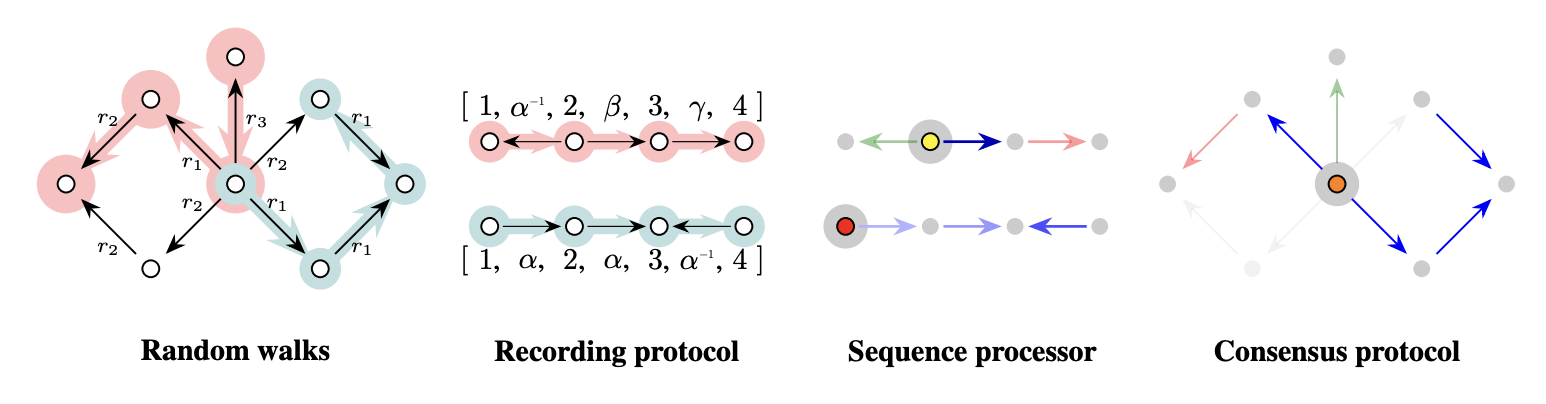



At a high level, FLOCK does the following:

1. **Random-walk sampling.** From each query (e.g., \((h, r, ?)\) or \((?, r, t)\)), FLOCK samples many non-backtracking random walks over the KG, jointly traversing nodes and relations.
2. **Recording protocol.** Each walk is converted into an **anonymized sequence** that hides raw IDs but preserves the relative roles and interaction pattern of nodes and relations.
3. **Sequence encoding.** A sequence model (e.g., a GRU) embeds these recorded walks over a new node–relation alphabet.
4. **Consensus protocol.** Node and relation representations are obtained by **pooling over many walks**, yielding individual embedding ready to be processed in the next layer that remain equivariant in distribution under node–relation permutations.

Theoretically, FLOCK is a **universal approximator** for isomorphism-invariant link-level functions on KGs while being more expressive than all deterministic node-relation equivariant KGFMs. Empirically, it separates relations that existing KGFM cannot distinguished  and achieves strong zero-shot performance across diverse KGs.

<p align="center">

# **Thank you for finishing this tutorial!**

</p>
